In [1]:
import os.path
from importlib import reload

import librosa as lib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from Signal_Analysis.features.signal import get_HNR
from vosk import Model
from scipy import signal, interpolate, ndimage

# tools work in progress
import tools
from tools import rec_vosk

reload(tools)


plt.style.use("dark_background")

mpl.rcParams["lines.linewidth"] = 0.5

plt.close("all")


model_path = "models/vosk-model-small-sv-rhasspy-0.15"

model = Model(model_path)


files = os.listdir("audio_preproc")

print(files)


file_path = os.path.join("audio_preproc", files[0])

['180923214834-Y20UOTIE-text-000_pp.wav', '181017140316-PM66PSO5-text-000_pp.wav', 'combo.wav', 'combo_pp.wav', 'female_canoe_pp.wav', 'svenska_combo_pp.wav']


## Split by words

In [2]:
vowel_set = set("e y u i o å a ö ä".split())
print(vowel_set)

{'i', 'e', 'u', 'o', 'ä', 'a', 'ö', 'å', 'y'}


In [3]:
Fs, audio = wavfile.read(file_path)

words = rec_vosk(file_path, model)

segments, vowels_per_segment = tools.segment_by_words(
    words, audio, Fs, vowel_set, min_conf=1
)

0 i ------------------- from 0.30 to 0.42 sec, confidence: 100.00%
1 skymningen ---------- from 0.42 to 1.26 sec, confidence: 100.00%
2 en ------------------ from 1.35 to 1.50 sec, confidence: 100.00%
3 mycket -------------- from 1.50 to 1.80 sec, confidence: 100.00%
4 het ----------------- from 1.83 to 2.10 sec, confidence: 100.00%
5 dag ----------------- from 2.10 to 2.43 sec, confidence: 100.00%
6 i ------------------- from 2.43 to 2.52 sec, confidence: 100.00%
7 början -------------- from 2.52 to 2.79 sec, confidence: 100.00%
8 av ------------------ from 2.79 to 2.91 sec, confidence: 100.00%
9 juli ---------------- from 2.91 to 3.36 sec, confidence: 100.00%
10 lämnade ------------- from 3.36 to 3.99 sec, confidence: 100.00%
11 en ------------------ from 3.99 to 4.14 sec, confidence: 100.00%
12 ung ----------------- from 4.14 to 4.41 sec, confidence: 100.00%
13 man ----------------- from 4.41 to 4.68 sec, confidence: 100.00%
14 sin ----------------- from 4.68 to 4.92 sec, confidence

In [4]:
print(f"# words  :{len(segments)}")
print(vowels_per_segment)

# words  :107
[['i'], ['y', 'i', 'e'], ['e'], ['y', 'e'], ['e'], ['a'], ['i'], ['ö', 'a'], ['a'], ['u', 'i'], ['ä', 'a', 'e'], ['e'], ['u'], ['a'], ['i'], ['a', 'a', 'e'], ['o'], ['a'], ['ö', 'e'], ['i'], [], ['a'], ['e'], ['u'], ['å'], ['a', 'a'], ['o'], ['ö', 'a', 'e'], ['å', 'a'], ['o'], ['e'], ['a', 'a'], ['o', 'e', 'u', 'a'], ['å'], ['o'], ['o'], ['o'], ['e'], ['y', 'i', 'i'], ['a'], ['a'], ['ö', 'e'], ['ä', 'i', 'a'], ['i'], ['a', 'a'], ['a'], ['a', 'a', 'e'], ['o'], ['å'], ['a', 'e', 'e'], ['i'], ['u', 'e'], ['e'], ['ö', 'a'], ['e'], ['e', 'o'], ['a', 'i'], ['y', 'a', 'e'], ['a'], ['i', 'a', 'e'], ['a'], ['a'], ['a'], ['ö', 'a'], ['e'], ['o', 'a'], ['ä', 'i', 'a'], ['o'], ['y', 'e'], ['u'], ['i'], ['u', 'a'], ['o'], ['ö'], ['o', 'o'], ['e'], ['i', 'a'], ['o'], ['a'], ['å'], ['o'], ['ä', 'i'], ['o', 'e'], ['ö'], ['i'], ['i'], ['e'], ['å', 'i', 'e'], ['a', 'a'], ['a', 'a'], ['e'], ['o'], ['ä'], ['a'], ['u', 'e'], ['u'], ['å', 'e'], ['e'], ['a', 'e', 'a'], ['ä', 'i', 'a'], ['e'], [

In [5]:
all_words_audio = tools.stitch_frames(segments, padding=Fs)

wavfile.write(os.path.join("output", "all_words.wav"), Fs, all_words_audio)

In [6]:
k = 7

x = segments[k].copy()
x = x / x.std()

wavfile.write(os.path.join("output", "one_word.wav"), Fs, tools.wavScaler(x))

In [7]:
print("vowels:", vowels_per_segment[k])

vowels: ['ö', 'a']


### Split by onset

In [8]:
splits_onset = lib.onset.onset_detect(y=x, sr=Fs, units="samples")
print(splits_onset)

[2560]


In [9]:
starts = np.concatenate(([0], splits_onset))
ends = np.concatenate((splits_onset, [len(x)]))
print(starts)
frames_onset = []
for s, e in zip(starts, ends):
    frames_onset.append(x[s:e])

print(len(frames_onset))

wavfile.write(
    "output/frames_onsets.wav",
    Fs,
    tools.stitch_frames(frames_onset, padding=Fs / 2),
)

[   0 2560]
2


In [10]:
hnr_frames_onset = [get_HNR(f, Fs) for f in frames_onset]

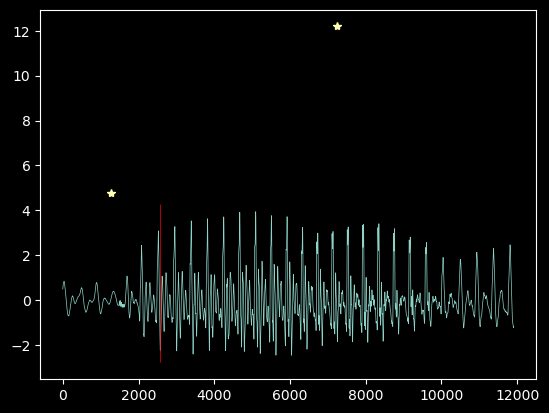

In [11]:
plt.figure()
plt.plot(x)
plt.vlines(splits_onset, *plt.ylim(), colors="r")
plt.plot((starts + ends) / 2, hnr_frames_onset, "*")
plt.show()

In [12]:
n_vowels = len(vowels_per_segment[k])
print(n_vowels, "vowels")

hnr_sort = np.argsort(-np.array(hnr_frames_onset))

frames_vowel = [frames_onset[i] for i in hnr_sort[:n_vowels]]

wavfile.write(
    f"output/vowels{n_vowels}.wav",
    Fs,
    tools.stitch_frames(frames_vowel, padding=Fs / 2),
)

2 vowels


## Idea, clustering

(12, 24)


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=745
  warnings.warn(
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=373
  warnings.warn(
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=187
  warnings.warn(
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=94
  warnings.warn(


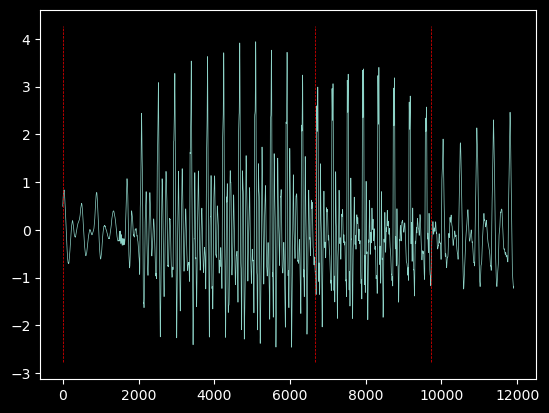

[   0 6656 9728]


In [24]:
chroma = lib.feature.chroma_cqt(y=x, sr=Fs)
s = lib.frames_to_samples(lib.segment.agglomerative(chroma, 3))

print(chroma.shape)


plt.figure()
plt.plot(x)
plt.vlines(s, *plt.ylim(), linestyles="dashed", color="r")
plt.show()

starts = s
ends = np.concatenate((s[1:], [len(x)]))
print(starts)
frames_chroma = []
for s, e in zip(starts, ends):
    frames_chroma.append(x[s:e])

wavfile.write(
    f"output/chroma{n_vowels}.wav",
    Fs,
    tools.stitch_frames(frames_chroma, padding=Fs / 2),
)

### idea, features(Hnr,power, etc)

## Idea, diff of power

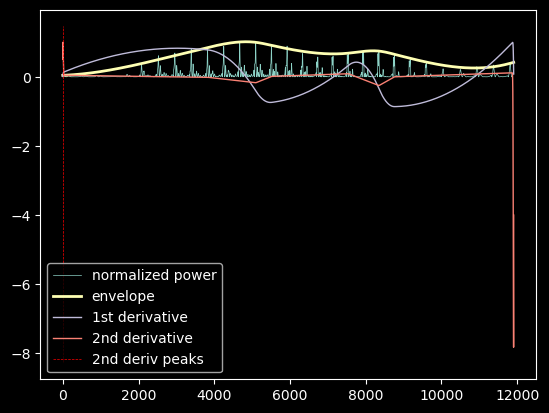

In [14]:
from tools import envelope

power = x**2
tt = np.arange(len(power))
power /= power.max()
env = envelope(power, 40)

env_d1 = np.gradient(env)
env_d1 /= env_d1.max()
env_d2 = np.gradient(env_d1)
env_d2 /= env_d2.max()

peaks_d2, peaks_d2_prop = signal.find_peaks(env_d2, height=0.2)

plt.figure()
plt.plot(power, label="normalized power")
plt.plot(tt, env, linewidth=2, label="envelope")
plt.plot(tt, env_d1, linewidth=1, label="1st derivative")
plt.plot(tt, env_d2, linewidth=1, label="2nd derivative")
plt.vlines(
    peaks_d2, *plt.ylim(), linestyles="dashed", colors="r", label="2nd deriv peaks"
)

plt.legend()
plt.show()

In [15]:
starts = np.concatenate(([0], peaks_d2))
ends = np.concatenate((peaks_d2, [len(x)]))

frames_pow = [x[s:e] for s, e in zip(starts, ends)]

print(len(frames_pow), "frames, length:")
for f in frames_pow:
    print(len(f))


frames_all_pow = tools.stitch_frames(frames_pow, fade_pow=0.2, padding=Fs)

wavfile.write("output/frames_split_pow.wav", Fs, frames_all_pow)

2 frames, length:
2
11905


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w


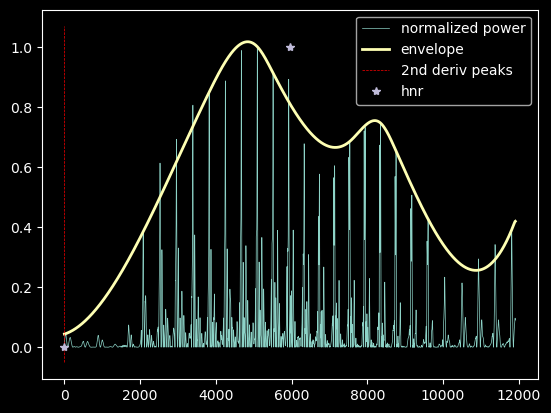

In [16]:
hnr_frames_pow = [get_HNR(f, Fs) for f in frames_pow]
hnr_frames_pow /= max(hnr_frames_pow)
plt.figure()
plt.plot(power, label="normalized power")
plt.plot(tt, env, linewidth=2, label="envelope")
plt.vlines(
    peaks_d2, *plt.ylim(), linestyles="dashed", colors="r", label="2nd deriv peaks"
)
plt.plot((starts + ends) / 2, hnr_frames_pow, "*", label="hnr")
plt.legend()
plt.show()

hnr_sort = np.argsort(-np.array(hnr_frames_pow))
n_vowels = len(vowels_per_segment[k])

frames_vowel = [frames_pow[i] for i in hnr_sort[:n_vowels]]

wavfile.write(
    f"output/vowels{n_vowels}_pow.wav",
    Fs,
    tools.stitch_frames(frames_vowel, padding=Fs / 2),
)